In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
from sklearn.pipeline import Pipeline
from ff_custom_scripts import *

In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

# Model

In [ ]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    categorical_features = cols_per_type(X_train, 'Ordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    ordinal_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of ordinal features: {len(ordinal_features)}')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(100, 1000),
            'regressor__learning_rate': space.Real(0.01, 0.05),
            'regressor__max_depth': space.Integer(2, 5),
            'regressor__subsample': space.Real(0.4, 0.8),
            'regressor__colsample_bytree': space.Real(0.4, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )
    
    model.fit(X_train, y_train)
    
    return model


# GPA

In [ ]:
gpa_model = run_model(train,target='gpa', classifier=False)

N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [ ]:
score_model(gpa_model,'gpa',test,leaderboard,holdout=None,classifier=False)

Metric: mean_squared_error
Best CV score: 0.3979
Standard deviation of CV scores: 0.0375
Mean CV score: 0.4094
Test MSE: 0.3920
Test R2: 0.1333
>> Leaderboard MSE: 0.3859
Leaderboard R2: 0.0120


# Material Hardship

In [ ]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [ ]:
model_materialHardship.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6138721865203991),
             ('regressor__learning_rate', 0.026903038203804172),
             ('regressor__max_depth', 3),
             ('regressor__n_estimators', 282),
             ('regressor__subsample', 0.7385616673608244)])

In [ ]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.0212
Standard deviation of CV scores: 0.0037
Mean CV score: 0.0219
Test MSE: 0.0196
Test R2: 0.2251
>> Leaderboard MSE: 0.0242
Leaderboard R2: 0.1536


# Grit


In [ ]:
model_grit = run_model(train,target='grit', classifier=False)

N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [ ]:
model_grit.best_params_

OrderedDict([('regressor__colsample_bytree', 0.41221838274599537),
             ('regressor__learning_rate', 0.021130901339300144),
             ('regressor__max_depth', 3),
             ('regressor__n_estimators', 454),
             ('regressor__subsample', 0.6904807538403688)])

In [ ]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2422
Standard deviation of CV scores: 0.0399
Mean CV score: 0.2503
Test MSE: 0.2280
Test R2: -0.0167
>> Leaderboard MSE: 0.2845
Leaderboard R2: -0.2949


# Eviction

In [ ]:
model_eviction = run_model(train,target='eviction', classifier=True)

N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [ ]:
model_eviction.best_params_

OrderedDict([('regressor__colsample_bytree', 0.5306473060393044),
             ('regressor__learning_rate', 0.03233783338131135),
             ('regressor__max_depth', 2),
             ('regressor__n_estimators', 572),
             ('regressor__scale_pos_weight', 5),
             ('regressor__subsample', 0.7471998635981993)])

In [ ]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.0514
Test F1: 0.0000
Leaderboard Brier: 0.0604
Number of positive predictions: 6
>> Leaderboard F1: 0.1111
Leaderboard Accuracy: 0.9396
Leaderboard Recall: 0.0667


Scores with threshold adjusment


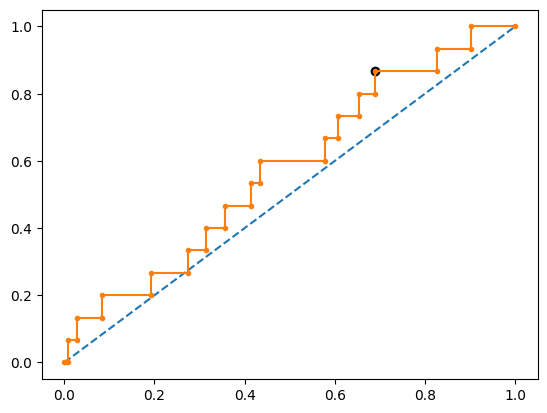

Threshold=0.015, FPR=0.690, TPR=0.867
Test brier: 0.664
Test F1: 0.110
Leaderboard Brier: 0.642
              precision    recall  f1-score   support

         0.0       0.97      0.33      0.49       500
         1.0       0.07      0.80      0.12        30

    accuracy                           0.36       530
   macro avg       0.52      0.57      0.31       530
weighted avg       0.91      0.36      0.47       530

Leaderboard F1: 0.124


In [ ]:
score_classifier(model_eviction, 'eviction', test, leaderboard, holdout=None)

# jobTraining

In [ ]:
model_job = run_model(train,target='jobTraining', classifier=True)

N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [ ]:
model_job.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6573580990269696),
             ('regressor__learning_rate', 0.03839797463244792),
             ('regressor__max_depth', 5),
             ('regressor__n_estimators', 497),
             ('regressor__scale_pos_weight', 8),
             ('regressor__subsample', 0.4089659185057217)])

In [ ]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.2432
Test F1: 0.3486
Leaderboard Brier: 0.3075
Number of positive predictions: 44
>> Leaderboard F1: 0.1466
Leaderboard Accuracy: 0.6925
Leaderboard Recall: 0.0952


Scores with threshold adjusment


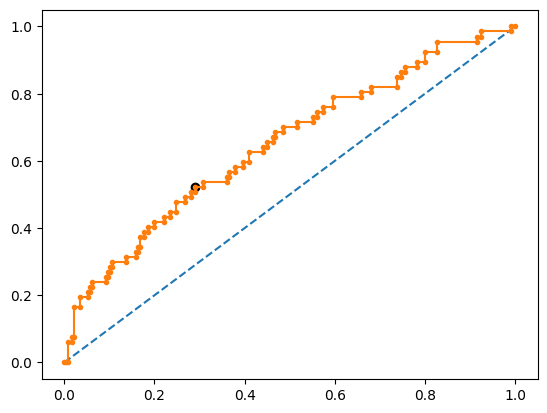

Threshold=0.276, FPR=0.289, TPR=0.522
Test brier: 0.336
Test F1: 0.410
Leaderboard Brier: 0.391
              precision    recall  f1-score   support

         0.0       0.72      0.75      0.73       383
         1.0       0.27      0.24      0.26       147

    accuracy                           0.61       530
   macro avg       0.50      0.50      0.50       530
weighted avg       0.60      0.61      0.60       530

Leaderboard F1: 0.258


In [ ]:
score_classifier(model_job, 'jobTraining', test, leaderboard, holdout=None)

# Layoff

In [ ]:
model_layoff = run_model(train, target='layoff', classifier=True)

N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [ ]:
model_layoff.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6573580990269696),
             ('regressor__learning_rate', 0.03839797463244792),
             ('regressor__max_depth', 5),
             ('regressor__n_estimators', 497),
             ('regressor__scale_pos_weight', 8),
             ('regressor__subsample', 0.4089659185057217)])

In [ ]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.2390
Test F1: 0.1176
Leaderboard Brier: 0.2472
Number of positive predictions: 28
>> Leaderboard F1: 0.1088
Leaderboard Accuracy: 0.7528
Leaderboard Recall: 0.0672


Scores with threshold adjusment


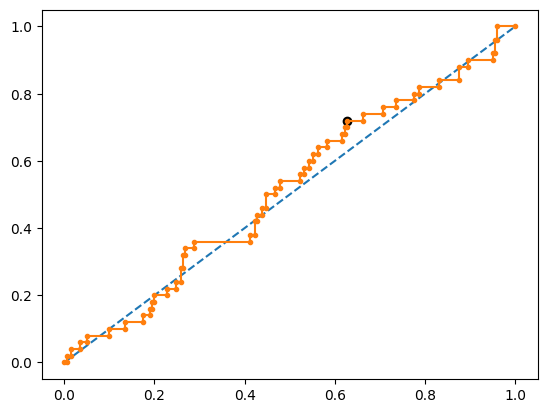

Threshold=0.086, FPR=0.627, TPR=0.720
Test brier: 0.562
Test F1: 0.332
Leaderboard Brier: 0.575
              precision    recall  f1-score   support

         0.0       0.76      0.37      0.50       411
         1.0       0.22      0.60      0.32       119

    accuracy                           0.42       530
   macro avg       0.49      0.49      0.41       530
weighted avg       0.64      0.42      0.46       530

Leaderboard F1: 0.318


In [ ]:
score_classifier(model_layoff, 'layoff', test, leaderboard, holdout=None)